In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import numpy as np
import cv2 as cv

In [ ]:
def plotTrainingHistory(history):
    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjusted figsize to better fit two subplots
    
    # Plot training and validation loss on the first subplot
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy on the second subplot
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Improve layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
def displayPerformanceFigures(real,pred,title,includeCF=True):
   if includeCF:
       # Compute confusion matrix
       cm = confusion_matrix(real, pred)
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
       plt.xlabel('Predicted labels')
       plt.ylabel('True labels')
       plt.title('Confusion Matrix for '+title+' samples')
       plt.show() 

   acc= accuracy_score(real, pred)
   print("Accuracy: ", acc)
    
   f1 = f1_score(real, pred, average='macro')
   print("F1 Score: ", f1)
   
def compile_and_train_model_then_evaluate_its_performance(mod,x_train,y_train,x_val,y_val,epochs_to_train,batch_s):
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # If the validation loss rises for 3 epochs training is stopped
    history = mod.fit(x_train, y_train, epochs=epochs_to_train, batch_size=batch_s, validation_data=(x_val, y_val), callbacks=callback)
    plotTrainingHistory(history)

    y_val_pred=np.argmax(mod.predict(x_val),axis=1)
    displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)

In [ ]:
data_dir = "images/classification/examples"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


In [ ]:
def dataset_to_numpy_ints(dataset):
    x = []
    y = []
    
    # Iterate through the dataset
    for image, label in dataset:
        # Rescale images from [0, 1] to [0, 255] and convert to uint8
        # SIFT requires uint8 values. (it is also the format of the images in the cifar-db)
        image_uint8 = (image.numpy() ).astype(np.uint8)
        #image_uint8 = (image.numpy() * 255).astype(np.uint8)
        x.append(image_uint8)  # Append the converted images
        y.append(label)  # Append labels directly
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    return x, y

In [ ]:
db_2_use = 'gas-bottle'

if db_2_use=='gas-bottle' :
    # the images have different sizes. Neural nets require always the same input size for each sample.
    # so we will rescale all img's
    img_height = 224 
    img_width = 224
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      )

    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      )

    class_names = train_ds.class_names

    # we want to reformat our data from 'data sets' to 'arrays'
    # at the same moment we also rescale the flower images to 0->256 (such that we have the same format for cifar-10 as for the flowers)
    x_train, y_train = dataset_to_numpy_ints(train_ds)
    x_val, y_val     = dataset_to_numpy_ints(val_ds)

NotFoundError: Could not find directory images/classification/examples

In [ ]:
num_classes=len(class_names)
num_classes

NameError: name 'class_names' is not defined

In [ ]:
max_value = np.amax(x_train)
min_value = np.amin(x_train)
print("Maximum value:", max_value)
print("Minimum value:", min_value)
scale=max_value

Maximum value: 255
Minimum value: 0


In [ ]:
class_names

['nok', 'ok']

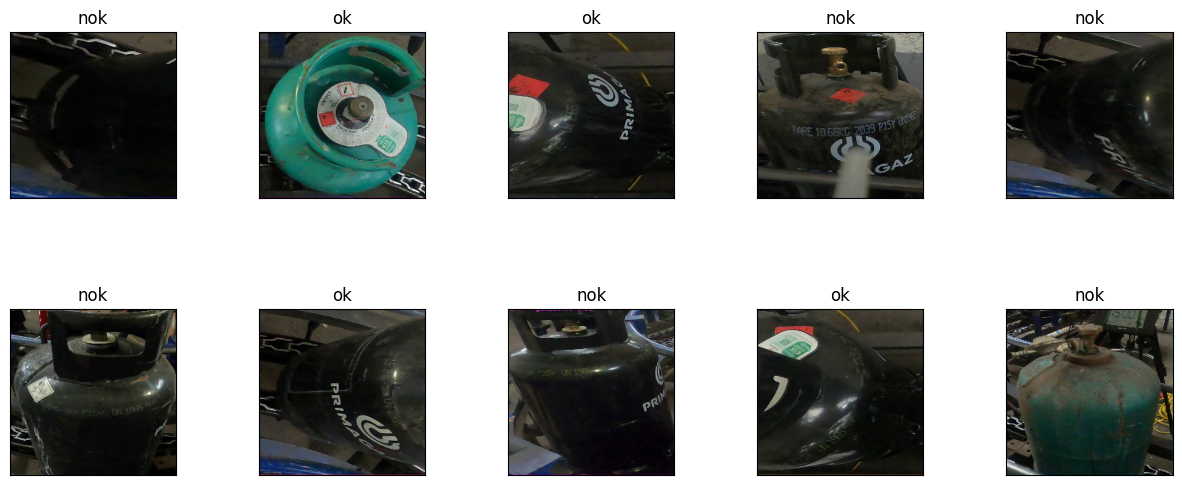

In [ ]:
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Adjust the spacing
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot the first 10 images
for i, ax in enumerate(axes.flat[:10]):
    # Display an image
    ax.imshow(x_train[i])
    
    # Title with the corresponding class name
    ax.set_title(f"{class_names[y_train[i]]}")
    
    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.show()

In [ ]:
tf.random.set_seed(42)  # to ensure cponsistent initialisation of th weigths  
my_kernel_size=3

layer_filters=[256,128,32] # when working with cifar-10 ...this one 
#layer_filters=[128,64,32] # when working with flowers....this one will be more feasible
#layer_filters=[256,128,32] # this combination was used above in the pre-lude

model = tf.keras.Sequential([
  
  tf.keras.layers.Input(shape=(img_width, img_height,3)),

  tf.keras.layers.Rescaling(1./scale, offset=-1),

  tf.keras.layers.Conv2D(filters=layer_filters[0],kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'), 
    

  tf.keras.layers.Conv2D(filters=layer_filters[1], kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),
  
  tf.keras.layers.Conv2D(filters=layer_filters[2], kernel_size=my_kernel_size, padding='same',activation='relu'),
  tf.keras.layers.MaxPooling2D(padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(units=num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,558,882 (13.58 MB)

 Trainable params: 3,558,882 (13.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs_to_train=25
batch_size = 64
cnn_weigths_file="cnn_classifier_"+db_2_use+"_ep_"+str(epochs_to_train)+'_'+str(layer_filters)+".weights.h5"
cnn_weigths_file

'cnn_classifier_gas-bottle_ep_25_[256, 128, 32].weights.h5'

In [ ]:
#load_or_train_weights='load' (in case you have trained this model before & saved the weights)
load_or_train_weights='train'
if load_or_train_weights=='load':
    model.load_weights(cnn_weigths_file, skip_mismatch=False)
    y_val_pred=np.argmax(model.predict(x_val),axis=1)
    displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)
else:    
    compile_and_train_model_then_evaluate_its_performance(model,x_train,y_train,x_val,y_val,epochs_to_train,batch_size)

Epoch 1/25
541/541 ━━━━━━━━━━━━━━━━━━━━ 18746s 35s/step - accuracy: 0.4970 - loss: 0.6940 - val_accuracy: 0.4893 - val_loss: 0.6934
Epoch 2/25
473/541 ━━━━━━━━━━━━━━━━━━━━ 26:29 23s/step - accuracy: 0.5018 - loss: 0.6931

: 

: 

In [ ]:
# Save the trained model in SavedModel format under models/new_classifier
models_dir = pathlib.Path('models')
models_dir.mkdir(parents=True, exist_ok=True)

save_path = models_dir / 'new_classifier'
model.save(save_path)  # saves in TensorFlow SavedModel format
print(f"Model saved to: {save_path}")